In [1]:
from MyDataset import TGS_Dataset
from Model import  Res34Unetv4
from Evaluation import do_kaggle_metric, dice_accuracy, do_mAP, unpad_im
from Loss import Lovasz_Hinge, DiceLoss, mixed_dice_bce_loss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import gc
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import Scheduler
import warnings
warnings.filterwarnings("ignore")
from torch.autograd import Variable

TRAIN_PATH = './Data/train'
LOAD_PATHS = None


OPTIMIZER = 'SGD'
PRETRAINED = False
N_EPOCH_PRETRAIN = 100
BATCH_SIZE = 32
NET = Res34Unetv4
ACTIVATION = 'relu'

LR = 3e-4
USE_SCHEDULER = 'CosineAnneling'
MILESTONES = [20, 40, 75]
GAMMA = 0.5
PATIENCE = 10
T_MAX = 70
T_MUL = 1
LR_MIN = 1e-6

print('load finish')

load finish


1562 empty masks out of 4000 total masks
Fold_0, Epoch_1/100, Step_100/100, Loss:0.366
Avg Train Loss: 0.7371895918250084
Avg Train IOU: 0.59232056
Avg Train mAP: 0.503625
Fold_0, Epoch_2/100, Step_100/100, Loss:0.273
Avg Train Loss: 0.4598379550874233
Avg Train IOU: 0.72710425
Avg Train mAP: 0.6766249999999999
Fold_0, Epoch_3/100, Step_100/100, Loss:0.383
Avg Train Loss: 0.41226338684558866
Avg Train IOU: 0.7479894
Avg Train mAP: 0.69759375
Fold_0, Epoch_4/100, Step_100/100, Loss:0.398
Avg Train Loss: 0.3829690596461296
Avg Train IOU: 0.77276444
Avg Train mAP: 0.72640625
Fold_0, Epoch_5/100, Step_100/100, Loss:0.391
Avg Train Loss: 0.34721791982650757
Avg Train IOU: 0.78250307
Avg Train mAP: 0.7426875000000002
After pretrained Epoch 5
Avg Val Loss: 1.0681539177894592
Avg Val IOU: 0.7206342
Avg Val mAP: 0.680625
Fold_0, Epoch_6/100, Step_100/100, Loss:0.209
Avg Train Loss: 0.347222268730402
Avg Train IOU: 0.7870811
Avg Train mAP: 0.74884375
Fold_0, Epoch_7/100, Step_100/100, Loss:0.647

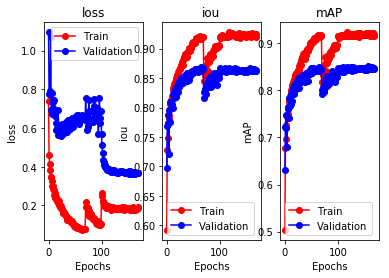

Fold_1, Epoch_1/100, Step_100/100, Loss:0.470
Avg Train Loss: 0.6926661184430123
Avg Train IOU: 0.62944746
Avg Train mAP: 0.5557500000000001
Fold_1, Epoch_2/100, Step_100/100, Loss:0.406
Avg Train Loss: 0.4563680762052536
Avg Train IOU: 0.7292151
Avg Train mAP: 0.6784375
Fold_1, Epoch_3/100, Step_100/100, Loss:0.589
Avg Train Loss: 0.4025492054224014
Avg Train IOU: 0.7667807
Avg Train mAP: 0.7254375000000001
Fold_1, Epoch_4/100, Step_100/100, Loss:0.342
Avg Train Loss: 0.36789039805531504
Avg Train IOU: 0.76981
Avg Train mAP: 0.7265937500000001
Fold_1, Epoch_5/100, Step_100/100, Loss:0.338
Avg Train Loss: 0.34779597088694575
Avg Train IOU: 0.7816704
Avg Train mAP: 0.7443125
After pretrained Epoch 5
Avg Val Loss: 0.7739207935333252
Avg Val IOU: 0.79310167
Avg Val mAP: 0.7573750000000001
Fold_1, Epoch_6/100, Step_100/100, Loss:0.287
Avg Train Loss: 0.32852653309702873
Avg Train IOU: 0.79346544
Avg Train mAP: 0.7569062500000001
Fold_1, Epoch_7/100, Step_100/100, Loss:0.213
Avg Train Loss:

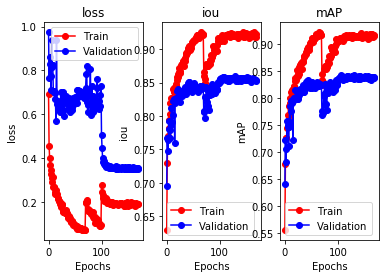

Fold_2, Epoch_1/100, Step_100/100, Loss:0.411
Avg Train Loss: 0.7093934819102288
Avg Train IOU: 0.61061466
Avg Train mAP: 0.5188437499999999
Fold_2, Epoch_2/100, Step_100/100, Loss:0.664
Avg Train Loss: 0.48045944675803187
Avg Train IOU: 0.71659774
Avg Train mAP: 0.6590312500000001
Fold_2, Epoch_3/100, Step_100/100, Loss:0.543
Avg Train Loss: 0.41557266891002653
Avg Train IOU: 0.7516899
Avg Train mAP: 0.7021562499999999
Fold_2, Epoch_4/100, Step_100/100, Loss:0.421
Avg Train Loss: 0.3769722235202789
Avg Train IOU: 0.7711713
Avg Train mAP: 0.7288125
Fold_2, Epoch_5/100, Step_100/100, Loss:0.338
Avg Train Loss: 0.35617795556783677
Avg Train IOU: 0.7799475
Avg Train mAP: 0.7372187500000001
After pretrained Epoch 5
Avg Val Loss: 0.7741034257411957
Avg Val IOU: 0.7885336
Avg Val mAP: 0.7625
Fold_2, Epoch_6/100, Step_100/100, Loss:0.236
Avg Train Loss: 0.33996649369597437
Avg Train IOU: 0.7855922
Avg Train mAP: 0.743125
Fold_2, Epoch_7/100, Step_100/100, Loss:0.237
Avg Train Loss: 0.32870838

In [ ]:
train_dataset = TGS_Dataset(TRAIN_PATH)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
cycle_inter = 70
loaders, ids = train_dataset.selfdefine_dataloader(num_workers=11, batch_size=BATCH_SIZE)
print_every = 100
print_epoch = 5

for ii, (train_loader, val_loader) in enumerate(loaders):
    model = NET(lr=LR, pretrained=PRETRAINED, fold=ii, activation=ACTIVATION)
    model = model.to(device)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = model.lr)
    model.scheduler = Scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, T_mul=T_MUL, lr_min=LR_MIN, val_mode='max',
                                                 last_epoch=-1, save_snapshots=True)
    # Training Round_1
    for epoch in range(epochs):
        epoch += 1
        model.epoch = epoch
        train_loss = []
        train_iou = []
        train_mAP = []
        val_loss = []
        val_iou = []
        val_mAP = []
        steps = 0
        CE = nn.CrossEntropyLoss()
        for j, (index, im, mask, z) in enumerate(train_loader):
            model.train()
            steps += 1
            mask = mask.cpu().numpy()
            is_empty = []
            for i in range(len(mask)):
                if np.sum(mask[i]) == 0:
                    is_empty.append(True)
                else:
                    is_empty.append(False)
            optimizer.zero_grad()
            mask = torch.from_numpy(mask)
            im, mask, z = im.cuda(), mask.cuda(), z.cuda()
            im, mask, z = Variable(im), Variable(mask), Variable(z)
            class_lbls = (torch.LongTensor(is_empty)).to(device)
            class_lbls = Variable(class_lbls)
            binary_logits, no_empty_logits, final_logits = model.forward(im, z)
            # bce loss
            bce_loss_final = mixed_dice_bce_loss(final_logits, mask, dice_weight=0.5, bce_weight=0.9)
            # class loss
            class_loss = CE(binary_logits, class_lbls)
            
            non_empty = []
            for c in range(len(is_empty)):
                if is_empty[c] == 0:
                    non_empty.append(c)
            
            has_empty_nonempty = False
            if len(non_empty) * len(is_empty) > 0:
                has_empty_nonempty = True
                
            loss = bce_loss_final + 0.05 * class_loss
            
            if has_empty_nonempty:
                indices = (torch.LongTensor(non_empty)).cuda()
                indices = Variable(indices)
                y_non_empty = torch.index_select(no_empty_logits, 0, indices)
                mask_non_empty = torch.index_select(mask, 0, indices)
                loss_no_empty = mixed_dice_bce_loss(y_non_empty, mask_non_empty, dice_weight=0.5, bce_weight=0.9)
                loss += 0.50 * loss_no_empty              
                
            pred = torch.sigmoid(final_logits)
            iou = dice_accuracy(pred, mask, is_average=False)
            mAP = do_mAP(pred.data.cpu().numpy(), mask.cpu().numpy(), is_average=False)
                      
            loss.backward()
            optimizer.step()
            stats = "Fold_{}, Epoch_{}/{}, Step_{}/{}, Loss:{:.3f}".format(
                ii, epoch, epochs, steps, len(train_loader), loss.item())
            print('\r' + stats, end="")
            
            train_loss.append(loss.item())
            train_iou.extend(iou)
            train_mAP.extend(mAP)
                
            if steps % print_every == 0:
                print('\r' + stats)
                print('Avg Train Loss:', np.mean(train_loss))
                print('Avg Train IOU:', np.mean([i.cpu().numpy() for i in train_iou]))
                print('Avg Train mAP:', np.mean(train_mAP))

        model.train_log['loss'].append(np.mean(train_loss))
        model.train_log['iou'].append(np.mean([i.cpu().numpy() for i in train_iou]))
        model.train_log['mAP'].append(np.mean(train_mAP))
        
        # validate the model
        for v, (index, im, mask, z) in enumerate(val_loader):
            model.eval()
            is_empty = []
            mask = mask.cpu().numpy()
            for i in range(len(mask)):
                if np.sum(mask[i]) == 0:
                    is_empty.append(True)
                else:
                    is_empty.append(False)
            mask = torch.from_numpy(mask)
            im, mask, z = im.cuda(), mask.cuda(), z.cuda()
            im, mask, z = Variable(im), Variable(mask), Variable(z)
            class_lbls = (torch.LongTensor(is_empty)).to(device)
            class_lbls = Variable(class_lbls)

            with torch.no_grad():
                binary_logits, no_empty_logits, final_logits = model.forward(im, z)
                pred = torch.sigmoid(final_logits)
                # class loss
                class_loss = CE(binary_logits, class_lbls)
                # Lovasz hinge loss
                lovasz_loss = model.criterion(final_logits, mask)
                loss = lovasz_loss + 0.01 * class_loss                                      
                iou = dice_accuracy(pred, mask, is_average=False)
                mAP = do_mAP(pred.cpu().numpy(), mask.cpu().numpy(), is_average=False)
            
            val_loss.append(loss.item())
            val_iou.extend(iou)
            val_mAP.extend(mAP)
            
        if epoch % print_epoch == 0:
            print('After pretrained Epoch {}'.format(epoch))    
            print('Avg Val Loss:', np.mean(val_loss))
            print('Avg Val IOU:', np.mean([i.cpu().numpy() for i in val_iou]))
            print('Avg Val mAP:', np.mean(val_mAP))
        
        model.val_log['loss'].append(np.mean(val_loss))
        model.val_log['iou'].append(np.mean([i.cpu().numpy() for i in val_iou]))
        model.val_log['mAP'].append(np.mean(val_mAP))
        
        # update lr
        model.scheduler.step(epoch, save_dict=dict(metric=np.mean(val_mAP),
                                                save_dir=model.save_dir,
                                                fold=model.fold,
                                                state_dict=model.state_dict()))
        # save best map model
        model.save_best_model(np.mean(val_mAP)) 
        
    LR_new = optimizer.param_groups[0]['lr'] 
    print('new_lr:', LR_new)
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                                lr=LR_new, momentum=0.9, weight_decay=0.0002)
    
    model.load_state_dict(torch.load(model.best_model_path))     
    # Leaning rate Scheduler
    model.scheduler = Scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, T_mul=T_MUL, lr_min=LR_MIN, val_mode='max',
                                                 last_epoch=-1, save_snapshots=True)
        
    # Training Round_2        
    for e in range(cycle_inter): 
        e += 1
        model.epoch = e
        train_loss = []
        train_iou = []
        train_mAP = []
        val_loss = []
        val_iou = []
        val_mAP = []
        steps = 0
        CE = nn.CrossEntropyLoss()
        
        for j, (index, im, mask, z) in enumerate(train_loader):
            model.train()
            steps += 1
            mask = mask.cpu().numpy()
            is_empty = []
            for i in range(len(mask)):
                if np.sum(mask[i]) == 0:
                    is_empty.append(True)
                else:
                    is_empty.append(False)
            optimizer.zero_grad()
            mask = torch.from_numpy(mask)
            im, mask, z = im.cuda(), mask.cuda(), z.cuda()
            im, mask, z = Variable(im), Variable(mask), Variable(z)
            class_lbls = (torch.LongTensor(is_empty)).to(device)
            class_lbls = Variable(class_lbls)
            binary_logits, no_empty_logits, final_logits = model.forward(im, z)
            # class loss
            class_loss = CE(binary_logits, class_lbls)   
            # Lovasz hinge loss
            lovasz_loss = model.criterion(final_logits, mask)
            
            non_empty = []
            for c in range(len(is_empty)):
                if is_empty[c] == 0:
                    non_empty.append(c)
            
            has_empty_nonempty = False
            if len(non_empty) * len(is_empty) > 0:
                has_empty_nonempty = True
                
            loss = lovasz_loss + 0.05 * class_loss
            
            if has_empty_nonempty:
                indices = (torch.LongTensor(non_empty)).cuda()
                indices = Variable(indices)
                y_non_empty = torch.index_select(no_empty_logits, 0, indices)
                mask_non_empty = torch.index_select(mask, 0, indices)
                loss_no_empty = mixed_dice_bce_loss(y_non_empty, mask_non_empty, dice_weight=0.5, bce_weight=0.9)
                loss += 0.50 * loss_no_empty
                
            pred = torch.sigmoid(final_logits)            
            iou = dice_accuracy(pred, mask, is_average=False)
            mAP = do_mAP(pred.data.cpu().numpy(), mask.cpu().numpy(), is_average=False)
            
            loss.backward()
            optimizer.step()
            
            stats = "Fold_{}, Epoch_{}/{}, Step_{}/{}, Loss:{:.3f}".format(
                ii, e, cycle_inter, steps, len(train_loader), loss.item())
            print('\r' + stats, end="")
            
            train_loss.append(loss.item())
            train_iou.extend(iou)
            train_mAP.extend(mAP)
                
            if e % print_every == 0:
                print('\r' + stats)
                print('Avg Train Loss:', np.mean(train_loss))
                print('Avg Train IOU:', np.mean([i.cpu().numpy() for i in train_iou]))
                print('Avg Train mAP:', np.mean(train_mAP))
        model.train_log['loss'].append(np.mean(train_loss))
        model.train_log['iou'].append(np.mean([i.cpu().numpy() for i in train_iou]))
        model.train_log['mAP'].append(np.mean(train_mAP))                    
              
        for v, (index, im, mask, z) in enumerate(val_loader):
            model.eval()
            is_empty = []
            mask = mask.cpu().numpy()
            for i in range(len(mask)):
                if np.sum(mask[i]) == 0:
                    is_empty.append(True)
                else:
                    is_empty.append(False)
            mask = torch.from_numpy(mask)
            im, mask, z = im.cuda(), mask.cuda(), z.cuda()
            im, mask, z = Variable(im), Variable(mask), Variable(z)
            class_lbls = (torch.LongTensor(is_empty)).to(device)
            class_lbls = Variable(class_lbls)

            with torch.no_grad():
                binary_logits, no_empty_logits, final_logits = model.forward(im, z)
                pred = torch.sigmoid(final_logits)
                # class loss
                class_loss = CE(binary_logits, class_lbls)
                # Lovasz hinge loss
                lovasz_loss = model.criterion(final_logits, mask)
                loss = lovasz_loss + 0.05 * class_loss                                      
                iou = dice_accuracy(pred, mask, is_average=False)
                mAP = do_mAP(pred.cpu().numpy(), mask.cpu().numpy(), is_average=False)
            
            val_loss.append(loss.item())
            val_iou.extend(iou)
            val_mAP.extend(mAP)
            
        if e % print_epoch == 0:    
            print('After Epoch {}'.format(e))    
            print('Avg Val Loss:', np.mean(val_loss))
            print('Avg Val IOU:', np.mean([i.cpu().numpy() for i in val_iou]))
            print('Avg Val mAP:', np.mean(val_mAP))
        
        model.val_log['loss'].append(np.mean(val_loss))
        model.val_log['iou'].append(np.mean([i.cpu().numpy() for i in val_iou]))
        model.val_log['mAP'].append(np.mean(val_mAP))
        
        model.scheduler.step(e, save_dict=dict(metric=np.mean(val_mAP),
                                                save_dir=model.save_dir,
                                                fold=model.fold,
                                                state_dict=model.state_dict()))
        # save best map model
        model.save_best_model(np.mean(val_mAP)) 
        
    model.plot_training_curve(show=True)
            
            
                         

